<!-- <p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Logo 1" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="Logo 2" width="200" style="margin-left: 20px;"/>
</p> -->

# Data Challenge : Leukemia Risk Prediction

### Participants Name : Nour RIZK, Vivien BRANDT


*GOAL OF THE CHALLENGE and WHY IT IS IMPORTANT:*

The goal of the challenge is to **predict disease risk for patients with blood cancer**, in the context of specific subtypes of adult myeloid leukemias. The risk is measured through the **overall survival** of patients, i.e. the duration of survival from the diagnosis of the blood cancer to the time of death or last follow-up. The performance metric used in the challenge is the **IPCW-C-Index**.

*THE DATASETS*

The **training set is made of 3,323 patients**. The **test set is made of 1,193 patients**. For each patient, you have acces to CLINICAL data and MOLECULAR data. The details of the data are as follows:

- OUTCOME:
  * OS_YEARS = Overall survival time in years
  * OS_STATUS = 1 (death) , 0 (alive at the last follow-up)

- CLINICAL DATA, with one line per patient:
  
  * ID = unique identifier per patient
  * CENTER = clinical center
  * BM_BLAST = Bone marrow blasts in % (blasts are abnormal blood cells)
  * WBC = White Blood Cell count in Giga/L 
  * ANC = Absolute Neutrophil count in Giga/L
  * MONOCYTES = Monocyte count in Giga/L
  * HB = Hemoglobin in g/dL
  * PLT = Platelets coutn in Giga/L
  * CYTOGENETICS = A description of the karyotype observed in the blood cells of the patients, measured by a cytogeneticist. Cytogenetics is the science of chromosomes. A karyotype is performed from the blood tumoral cells. The convention for notation is ISCN (https://en.wikipedia.org/wiki/International_System_for_Human_Cytogenomic_Nomenclature). Cytogenetic notation are: https://en.wikipedia.org/wiki/Cytogenetic_notation. Note that a karyotype can be normal or abnornal. The notation 46,XX denotes a normal karyotype in females (23 pairs of chromosomes including 2 chromosomes X) and 46,XY in males (23 pairs of chromosomes inclusing 1 chromosme X and 1 chromsome Y). A common abnormality in the blood cancerous cells might be for exemple a loss of chromosome 7 (monosomy 7, or -7), which is typically asssociated with higher risk disease

- GENE MOLECULAR DATA, with one line per patient per somatic mutation. Mutations are detected from the sequencing of the blood tumoral cells. 
We call somatic (= acquired) mutations the mutations that are found in the tumoral cells but not in other cells of the body.

  * ID = unique identifier per patient
  * CHR START END = position of the mutation on the human genome
  * REF ALT = reference and alternate (=mutant) nucleotide
  * GENE = the affected gene
  * PROTEIN_CHANGE = the consequence of the mutation on the protei that is expressed by a given gene
  * EFFECT = a broad categorization of the mutation consequences on a given gene.
  * VAF = Variant Allele Fraction = it represents the **proportion** of cells with the deleterious mutations. 

In [ ]:
# Import necessary libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw
from sklearn.impute import SimpleImputer
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import xgboost as xgb

import os
import re

In [230]:
# Helper function for "now"
import datetime
def now_str():
    now = datetime.datetime.now()
    return now.strftime("%Y-%m-%d_%H-%M")

In [ ]:
# Files in the directory 
# run this command to check that you have the same file structure as the one on the github repo
# print(os.listdir("."))        

# Clinical Data
df = pd.read_csv("data/X_train/clinical_train.csv")
df_eval = pd.read_csv("data/X_test/clinical_test.csv")

# Molecular Data
maf_df = pd.read_csv("data/X_train/molecular_train.csv")
maf_eval = pd.read_csv("data/X_test/molecular_test.csv")

target_df = pd.read_csv("data/target_train.csv")
# target_df_test = pd.read_csv("./target_test.csv")     # once made available by the challenge providers

df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


### Step 1.a: Data Preparation (Clinical data)

For survival analysis, we’ll format the dataset so that OS_YEARS represents the time variable and OS_STATUS represents the event indicator.

In [ ]:
### Starting of Data Cleaning and Preprocessing

# Drop rows where 'OS_YEARS' is NaN if conversion caused any issues
target_df.dropna(subset=['OS_YEARS', 'OS_STATUS'], inplace=True)

# percentage of rows dropped:
print(f'Percentage of initially dropt rows {(1 - target_df.shape[0] / df.shape[0]) * 100:.2f}%')

# Check the data types to ensure 'OS_STATUS' is boolean and 'OS_YEARS' is numeric
print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)

# Contarget_dfvert 'OS_YEARS' to numeric if it isn’t already
target_df['OS_YEARS'] = pd.to_numeric(target_df['OS_YEARS'], errors='coerce')

# Ensure 'OS_STATUS' is boolean
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool)

Percentage of initially dropt rows 4.51%
OS_STATUS    float64
OS_YEARS     float64
dtype: object


In [233]:
### Feature Selection :

# features they selected for the Benchmark model :
features_basic = ['BM_BLAST', 'HB', 'PLT']

# Construct some features based on scientific knowledge, and add them to the dataframe and the features list
df['BLAST_per_WBC'] = df['BM_BLAST'] / (df['WBC'] + 1e-8)
df['ANC_per_WBC'] = df['ANC'] / (df['WBC'] + 1e-8)
df["PL_per_HB"] = df['PLT'] / (df['HB'] + 1e-8)

# add these features to the features list
features_additional = ['BLAST_per_WBC', 'ANC_per_WBC', 'PL_per_HB']

df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,BLAST_per_WBC,ANC_per_WBC,PL_per_HB
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",5.000000,0.071429,15.657895
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",0.135135,0.324324,3.620690
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",4.054054,0.567568,5.704225
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",0.256410,0.487179,8.651685
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",0.046875,0.075781,17.567568


In [234]:
# Same operations for df_eval

df_eval['BLAST_per_WBC'] = df_eval['BM_BLAST'] / (df_eval['WBC'] + 1e-8)
df_eval['ANC_per_WBC'] = df_eval['ANC'] / (df_eval['WBC'] + 1e-8)
df_eval["PL_per_HB"] = df_eval['PLT'] / (df_eval['HB'] + 1e-8)
df_eval.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,BLAST_per_WBC,ANC_per_WBC,PL_per_HB
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,"47,XY,+X,del(9)(q?)[15]/47,XY,+X[5]",19.710145,0.17,6.315789
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,"46,XY,der(3)?t(3;11)(q26.2;q23),add(4)(p15).de...",11.006289,0.39,3.200000
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,"47,XX,+8",NaN,0.70,2.032520
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,Normal,10.990991,0.37,5.500000
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,"43,XY,dic(5;17)(q11.2;p11.2),-7,-13,-20,-22,+r...",1.652893,0.61,3.139535


####  Working on cytogenetic column data

In [235]:
# Define patterns for key cytogenetic abnormalities
cytogenetic_markers = {
    "Has_Monosomy_7": r"-7",
    "Has_Trisomy_8": r"\+8",
    "Has_Del_5q": r"del\(5\)",
    "Has_Del_20q": r"del\(20\)",
    "Has_Del_17p": r"del\(17\)",
    "Has_T_3_3": r"t\(3;3\)",
    "Has_Complex_Karyotype": r"complex",
    "Has_Trisomy_21": r"\+21",
    "Has_Trisomy_22": r"\+22",
    "Has_T_9_11": r"t\(9;11\)",
    "Has_T_15_17": r"t\(15;17\)",
    "Has_Inv_3": r"inv\(3\)"
}

# Function to extract cytogenetic abnormalities as separate binary features
def extract_cytogenetic_features(cytogenetics):
    features = {}
    
    # If missing or empty, set all to 0
    if pd.isna(cytogenetics) or cytogenetics.strip() == "":
        for key in cytogenetic_markers:
            features[key] = 0
        features["Complexity_Score"] = 0
        return features

    cytogenetics = cytogenetics.upper()
    
    # Check for each abnormality
    for key, pattern in cytogenetic_markers.items():
        features[key] = int(bool(re.search(pattern, cytogenetics)))

    # Compute complexity score (count of detected abnormalities)
    features["Complexity_Score"] = sum(features.values())

    return features

# Apply function to create new binary columns
cyto_features_df = df["CYTOGENETICS"].apply(extract_cytogenetic_features).apply(pd.Series)

# Merge new binary cytogenetic features into the main dataframe
df = pd.concat([df, cyto_features_df], axis=1)

# Drop the original cytogenetics column (no longer needed)
df.drop(columns=["CYTOGENETICS"], inplace=True)

# Display updated dataframe with binary cytogenetic features
df.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,BLAST_per_WBC,ANC_per_WBC,...,Has_Del_20q,Has_Del_17p,Has_T_3_3,Has_Complex_Karyotype,Has_Trisomy_21,Has_Trisomy_22,Has_T_9_11,Has_T_15_17,Has_Inv_3,Complexity_Score
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,5.000000,0.071429,...,0,0,0,0,0,0,0,0,0,0
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,0.135135,0.324324,...,0,0,0,0,0,0,0,0,0,0
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,4.054054,0.567568,...,0,0,0,0,0,0,0,0,0,0
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,0.256410,0.487179,...,0,0,0,0,0,0,0,0,0,0
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,0.046875,0.075781,...,0,0,0,0,0,0,0,0,0,0


In [236]:
# do the same for the eval set
cyto_features_df_eval = df_eval["CYTOGENETICS"].apply(extract_cytogenetic_features).apply(pd.Series)
df_eval = pd.concat([df_eval, cyto_features_df_eval], axis=1)
df_eval.drop(columns=["CYTOGENETICS"], inplace=True)
df_eval.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,BLAST_per_WBC,ANC_per_WBC,...,Has_Del_20q,Has_Del_17p,Has_T_3_3,Has_Complex_Karyotype,Has_Trisomy_21,Has_Trisomy_22,Has_T_9_11,Has_T_15_17,Has_Inv_3,Complexity_Score
0,KYW1,KYW,68.0,3.45,0.5865,NaN,7.6,48.0,19.710145,0.17,...,0,0,0,0,0,0,0,0,0,0
1,KYW2,KYW,35.0,3.18,1.2402,NaN,10.0,32.0,11.006289,0.39,...,0,0,0,0,0,0,0,0,0,0
2,KYW3,KYW,NaN,12.40,8.6800,NaN,12.3,25.0,NaN,0.70,...,0,0,0,0,0,0,0,0,0,1
3,KYW4,KYW,61.0,5.55,2.0535,NaN,8.0,44.0,10.990991,0.37,...,0,0,0,0,0,0,0,0,0,0
4,KYW5,KYW,2.0,1.21,0.7381,NaN,8.6,27.0,1.652893,0.61,...,0,0,0,0,0,0,0,0,0,1


In [237]:
features_cytogenetics = list(cyto_features_df.columns)
print("The cytogenetic data are :", features_cytogenetics)
print(len(features_cytogenetics))

The cytogenetic data are : ['Has_Monosomy_7', 'Has_Trisomy_8', 'Has_Del_5q', 'Has_Del_20q', 'Has_Del_17p', 'Has_T_3_3', 'Has_Complex_Karyotype', 'Has_Trisomy_21', 'Has_Trisomy_22', 'Has_T_9_11', 'Has_T_15_17', 'Has_Inv_3', 'Complexity_Score']
13


In [238]:
print(df_eval.shape)
print(df.shape)
# So we overall added 13 features to the dataframe

(1193, 24)
(3323, 24)


### Step 1.b : Data Preparation (Molecular Data)

In [ ]:
# Load molecular data
mutation_data = maf_df.copy()  # Assuming maf_df contains molecular variants

# One-hot encode gene mutations
mutation_features = mutation_data.pivot_table(index='ID', columns='GENE', values='VAF', aggfunc='max').fillna(0)

# One-hot encode mutation effects
mutation_effects = pd.get_dummies(mutation_data[['ID', 'EFFECT']], columns=['EFFECT']).groupby('ID').sum()

# Update feature list
molecular_features = list(mutation_features.columns)
molecular_effect = list(mutation_effects.columns)

print(df.shape)
print(mutation_effects.shape)
print(mutation_features.shape)

(3323, 24)
(3026, 16)
(3024, 124)


In [ ]:
# do the same to the eval set
mutation_data_eval = maf_eval.copy()
mutation_features_eval = mutation_data_eval.pivot_table(index='ID', columns='GENE', values='VAF', aggfunc='max').fillna(0)
mutation_effects_eval = pd.get_dummies(mutation_data_eval[['ID', 'EFFECT']], columns=['EFFECT']).groupby('ID').sum()

# define the list of molecular features of the eval set
molecular_features_eval = list(mutation_features_eval.columns)
molecular_effect_eval = list(mutation_effects_eval.columns)

print(df_eval.shape)
print(mutation_effects_eval.shape)
print(mutation_features_eval.shape)

(1193, 24)
(1054, 8)
(1054, 83)


In [241]:
# Let's get the common molecular features between the train and the eval set
common_molecular_features = set(molecular_features).intersection(set(molecular_features_eval))
print("The number of common molecular feature is", len(common_molecular_features))

# Now, let's merge df to maf_df and df_eval to maf_evaln only on the common features
df = df.merge(mutation_features[list(common_molecular_features)], on='ID', how='left').fillna(0)
df_eval = df_eval.merge(mutation_features_eval[list(common_molecular_features)], on='ID', how='left').fillna(0)

common_molecular_effect = set(molecular_effect).intersection(set(molecular_effect_eval))
print("The number of common molecular effect is",len(common_molecular_effect))
df = df.merge(mutation_effects[list(common_molecular_effect)], on='ID', how='left').fillna(0)
df_eval = df_eval.merge(mutation_effects_eval[list(common_molecular_effect)], on='ID', how='left').fillna(0)

The number of common molecular feature is 64
The number of common molecular effect is 8


In [242]:
list_molecular_info = list(common_molecular_features) + list(common_molecular_effect)
features = features_basic + features_additional + features_cytogenetics + list_molecular_info
print(len(features))

91


Now, we retain the influence of "out of intersection" mutations by constructing a macroscopic proxy features: the total number of somatic mutations per patients **Nmut** feature. Instead of analyzing specific "out of intersection" mutations or their biological impact, we use this aggregate count as a basic feature to reflect the mutational burden for each individual. Although simplistic, this feature can serve as a general indicator of genetic variability across patients, which may influence survival outcomes. 

In [243]:
# Step: Extract the number of somatic mutations per patient
# Group by 'ID' and count the number of mutations (rows) per patient
tmp = maf_df.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_2 = df.merge(tmp, on='ID', how='left').fillna({'Nmut': 0})

In [244]:
# do the same for the df_eval :
# Adding the Nmut feature to the evaluation dataset
tmp_eval = maf_eval.groupby('ID').size().reset_index(name='Nmut')

# Merge with the training dataset and replace missing values in 'Nmut' with 0
df_eval = df_eval.merge(tmp_eval, on='ID', how='left').fillna({'Nmut': 0})

df_eval.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,BLAST_per_WBC,ANC_per_WBC,...,U2AF2,EFFECT_PTD,EFFECT_ITD,EFFECT_stop_gained,EFFECT_frameshift_variant,EFFECT_stop_lost,EFFECT_inframe_codon_gain,EFFECT_non_synonymous_codon,EFFECT_inframe_codon_loss,Nmut
0,KYW1,KYW,68.0,3.45,0.5865,0.0,7.6,48.0,19.710145,0.17,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0
1,KYW2,KYW,35.0,3.18,1.2402,0.0,10.0,32.0,11.006289,0.39,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0
2,KYW3,KYW,0.0,12.40,8.6800,0.0,12.3,25.0,0.000000,0.70,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,3.0
3,KYW4,KYW,61.0,5.55,2.0535,0.0,8.0,44.0,10.990991,0.37,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0
4,KYW5,KYW,2.0,1.21,0.7381,0.0,8.6,27.0,1.652893,0.61,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0


In [ ]:
# Select features

features = features + ['Nmut']
target = ['OS_YEARS', 'OS_STATUS']

# Create the survival data format
X = df_2.loc[df_2['ID'].isin(target_df['ID']), features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)

print(target_df[['OS_STATUS', 'OS_YEARS']].dtypes)
print(X.shape)

###  The final created features


In [ ]:
print("The features are:", features)
print(len(features))

The features are: ['BM_BLAST', 'HB', 'PLT', 'BLAST_per_WBC', 'ANC_per_WBC', 'PL_per_HB', 'Has_Monosomy_7', 'Has_Trisomy_8', 'Has_Del_5q', 'Has_Del_20q', 'Has_Del_17p', 'Has_T_3_3', 'Has_Complex_Karyotype', 'Has_Trisomy_21', 'Has_Trisomy_22', 'Has_T_9_11', 'Has_T_15_17', 'Has_Inv_3', 'Complexity_Score', 'CALR', 'ASXL2', 'SH2B3', 'NOTCH1', 'SRSF2', 'CEBPA', 'STAT3', 'ARID2', 'ASXL1', 'WT1', 'PPM1D', 'TERT', 'KRAS', 'ETNK1', 'U2AF1', 'SETBP1', 'NPM1', 'JAK2', 'STAG2', 'MPL', 'DNMT3A', 'DDX41', 'FLT3', 'SMC1A', 'BCORL1', 'SF3B1', 'EGFR', 'CTCF', 'BRAF', 'CUX1', 'EZH2', 'IRF1', 'CREBBP', 'NF1', 'RAD21', 'NRAS', 'GNB1', 'PTPN11', 'PHF6', 'IDH2', 'JARID2', 'BRCC3', 'RUNX1', 'TP53', 'CBL', 'SUZ12', 'SMC3', 'KIT', 'ETV6', 'CSF3R', 'GNAS', 'PRPF8', 'ZRSR2', 'TET2', 'NFE2', 'CHEK2', 'BCOR', 'CSNK1A1', 'GATA2', 'MLL', 'IDH1', 'KDM6A', 'CDKN2A', 'U2AF2', 'EFFECT_PTD', 'EFFECT_ITD', 'EFFECT_stop_gained', 'EFFECT_frameshift_variant', 'EFFECT_stop_lost', 'EFFECT_inframe_codon_gain', 'EFFECT_non_synony

### Step 2: Feature selection and Splitting the Dataset and Z norm 

We will perform feature selection by first checking if there is a strong correlation between certain features

Text(0.5, 1.0, 'Feature Correlation Matrix')

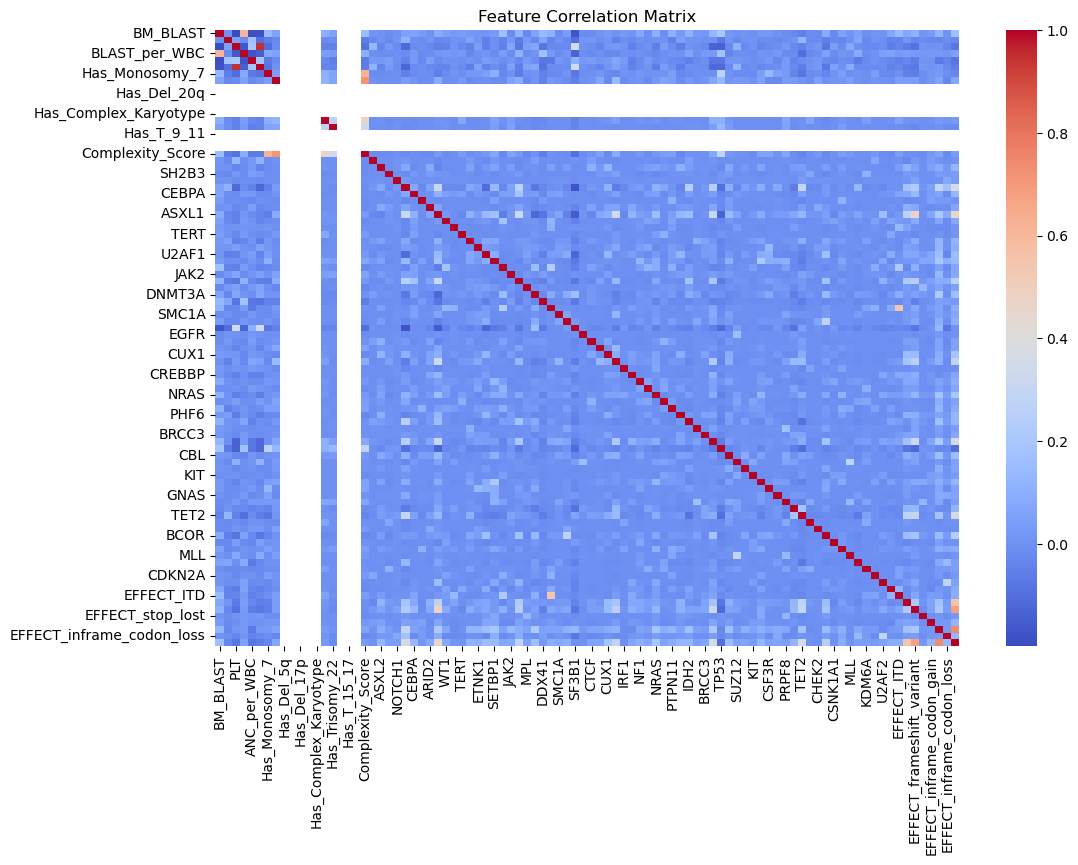

In [248]:
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")

We observe strong correlations between certain features in the top left matrix.

In [ ]:
# Also, we verify if there are totally null columns
null_columns = X.columns[X.isnull().all()]
print(null_columns)

Index([], dtype='object')


In [ ]:
# Define a threshold of correlation and print all the pairs of features that are highly correlated
threshold = 0.75
print("Original total number of features", len(features))
for i in range(len(features)):
    for j in range(i+1, len(features)):
        if corr_matrix.iloc[i, j] > threshold:
            print(f"Features {features[i]} and {features[j]} are highly correlated with a correlation of {corr_matrix.iloc[i, j]:.2f}")

92
Features PLT and PL_per_HB are highly correlated with a correlation of 0.95


In [ ]:
# now that we have the pairs of highly correlated features, we can drop them
corr_feature = 'PL_per_HB'
features.remove(corr_feature)

# update the training and testing sets
X = X.drop(columns=[corr_feature])

print(f"We now have {len(features)} features")

We now have 91 features


Now we can perform our split, Impute the data and Z-normalization.

In [252]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Compute percentage of missing values per column
missing_percentage = X_train.isnull().mean() * 100
# Define a threshold for dropping columns with too many missing values
threshold = 10
# Print the columns with more than 10% missing values
print(missing_percentage[missing_percentage > threshold])

# Survival-aware imputation for missing values
imputer = SimpleImputer(strategy="median")
X_train[features] = imputer.fit_transform(X_train[features])
X_test[features] = imputer.transform(X_test[features])

In [253]:
# Z normalizing the data :
data_scaler = StandardScaler()
# We decide to keep the dataframe format
X_train_znorm = pd.DataFrame(data_scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_znorm = pd.DataFrame(data_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

### Step 3: Training Standard Machine Learning Methods (as presented in the Benchmark Notebook)

In this step, we train a standard LightGBM model on survival data, but we do not account for censoring. Instead of treating the event status, we use only the observed survival times as the target variable. This approach disregards whether an individual’s event (e.g., death) was observed or censored, effectively treating the problem as a standard regression task. While this method provides a basic benchmark, it may be less accurate than survival-specific models, as it does not leverage the information contained in censored observations.

In [255]:
# Define LightGBM parameters
lgbm_params = {
    'max_depth': 3,        
    'learning_rate': 0.05,
    'verbose': -1,
    # 'alpha': 100,
}

# Prepare the data for LightGBM
# Scale the target (OS_YEARS) to reduce skew, apply weights based on event status
X_train_lgb = X_train_znorm  # Features for training
y_train_transformed = y_train['OS_YEARS']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Make predictions on the training and testing sets
pred_train = -model.predict(X_train_znorm)
pred_test = -model.predict(X_test_znorm)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, pred_train, tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, pred_test, tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")


LightGBM Survival Model Concordance Index IPCW on train: 0.74
LightGBM Survival Model Concordance Index IPCW on test: 0.69


#### Training a standard XGBoost model

In [256]:
# train a XGBoost model for survival analysis
xgb_params = {
    # "objective": "rank:pairwise",  # Optimized for ranking risk scores
    # "eval_metric": "ndcg",  # Normalized Discounted Cumulative Gain
    'max_depth': 3,
    'learning_rate': 0.01,
    'verbosity': 0,
}

# Prepare the data for XGBoost
X_train_xgb = X_train_znorm
y_train_xgb = y_train['OS_YEARS']

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)

# Train the XGBoost model
xgb_model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=100)

# Make predictions on the training and testing sets
dtest_train = xgb.DMatrix(X_train_znorm)
dtest_test = xgb.DMatrix(X_test_znorm)
pred_train_xgb = -xgb_model.predict(dtest_train)
pred_test_xgb = -xgb_model.predict(dtest_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw_xgb = concordance_index_ipcw(y_train, y_train, pred_train_xgb, tau=7)[0]
test_ci_ipcw_xgb = concordance_index_ipcw(y_train, y_test, pred_test_xgb, tau=7)[0]
print(f"XGBoost Survival Model Concordance Index IPCW on train: {train_ci_ipcw_xgb:.2f}")
print(f"XGBoost Survival Model Concordance Index IPCW on test: {test_ci_ipcw_xgb:.2f}")

XGBoost Survival Model Concordance Index IPCW on train: 0.72
XGBoost Survival Model Concordance Index IPCW on test: 0.69


#### Grid Search for the XGBoost 

In [ ]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'verbosity': [0]
}

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor()

# Initialize GridSearchCV with the XGBoost model and parameter grid
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Prepare the data for XGBoost
X_train_xgb = X_train_znorm
y_train_xgb = y_train['OS_YEARS']

# Fit the grid search to the training data
grid_search.fit(X_train_xgb, y_train_xgb)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best score found: {best_score}")

# Train the XGBoost model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train_xgb, y_train_xgb)

# Make predictions on the training and testing sets
dtest_train = xgb.DMatrix(X_train_znorm)
dtest_test = xgb.DMatrix(X_test_znorm)
pred_train_xgb = -best_xgb_model.predict(dtest_train)
pred_test_xgb = -best_xgb_model.predict(dtest_test)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw_xgb = concordance_index_ipcw(y_train, y_train, pred_train_xgb, tau=7)[0]
test_ci_ipcw_xgb = concordance_index_ipcw(y_train, y_test, pred_test_xgb, tau=7)[0]
print(f"XGBoost Survival Model Concordance Index IPCW on train: {train_ci_ipcw_xgb:.2f}")
print(f"XGBoost Survival Model Concordance Index IPCW on test: {test_ci_ipcw_xgb:.2f}")


Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'verbosity': 0}
Best score found: -6.002876353390284


/users/eleves-b/2021/vivien.brandt/.local/lib/python3.9/site-packages/xgboost/data.py:1138: UserWarning: Unknown data type: <class 'xgboost.core.DMatrix'>, trying to convert it to csr_matrix
  warnings.warn(


TypeError: Not supported type for data.<class 'xgboost.core.DMatrix'>

### Step 4: Cox Proportional Hazards Model

To account for censoring in survival analysis, we use a Cox Proportional Hazards (Cox PH) model, a widely used method that estimates the effect of covariates on survival times without assuming a specific baseline survival distribution. The Cox PH model is based on the hazard function, $h(t | X)$, which represents the instantaneous risk of an event (e.g., death) at time $t$ given covariates $X$. The model assumes that the hazard can be expressed as:

$$h(t | X) = h_0(t) \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)$$


where $h_0(t)$ is the baseline hazard function, and $\beta$ values are coefficients for each covariate, representing the effect of $X$ on the hazard. Importantly, the proportional hazards assumption implies that the hazard ratios between individuals are constant over time. This approach effectively leverages both observed and censored survival times, making it a more suitable method for survival data compared to standard regression techniques that ignore censoring.


In [ ]:
# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis(alpha=10.0)
cox.fit(X_train, y_train)
# Observation : better performance without Z normalization

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.71
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.70


### Step 5 : Random Survival Forest model 

In [ ]:
# Initialize and train Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=5, max_depth=5, random_state=42, oob_score=True)
rsf.fit(X_train_znorm, y_train)
# Observation : similar results with and without Z normalization

# Evaluate using IPCW Concordance Index
rsf_cindex_train = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train_znorm), tau=7)[0]
rsf_cindex_test = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test_znorm), tau=7)[0]

print(f"RSF Concordance Index IPCW on train: {rsf_cindex_train:.2f}")
print(f"RSF Concordance Index IPCW on test: {rsf_cindex_test:.2f}")

RSF Concordance Index IPCW on train: 0.72
RSF Concordance Index IPCW on test: 0.70


### Cross Validation for RSF model

In [277]:
from sklearn.model_selection import cross_val_score
from sksurv.metrics import concordance_index_censored

In [ ]:
# Define a function to compute the IPCW concordance index for cross-validation
def ipcw_cindex(estimator, X, y):
    predictions = estimator.predict(X)
    return concordance_index_ipcw(y, y, predictions, tau=7)[0]

# Impute and Z-normalize the features X
X[features] = imputer.transform(X[features])
X_znorm = pd.DataFrame(data_scaler.transform(X), columns=X.columns, index=X.index)

# Perform cross-validation
cv_scores = cross_val_score(rsf, X_znorm, y, cv=5, scoring=ipcw_cindex)

# Print the cross-validation scores
print(f"Cross-validation IPCW C-index scores: {cv_scores}")
print(f"Mean IPCW C-index: {cv_scores.mean():.2f}")
print(f"Standard Deviation of IPCW C-index: {cv_scores.std():.2f}")

Cross-validation IPCW C-index scores: [0.72939306 0.7281003  0.69395008 0.69621593 0.66786717]
Mean IPCW C-index: 0.70
Standard Deviation of IPCW C-index: 0.02


### Grid Search for RSF model

In [ ]:
# Grid search for the best hyperparameters for RSF
# Define the parameter grid for the Random Survival Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# Initialize the Random Survival Forest model
rsf = RandomSurvivalForest(random_state=42)

# Initialize GridSearchCV with the RSF model and parameter grid
grid_search = GridSearchCV(estimator=rsf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(X_train_znorm, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best score found: {best_score}")

/users/eleves-b/2021/vivien.brandt/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/users/eleves-b/2021/vivien.brandt/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/users/eleves-b/2021/vivien.brandt/.local/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/users/eleves-b/2021/vivien.brandt/.local/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "/users/eleves-b/2021/vivien.brandt/.local/lib/python3.9/site-packages/sklearn/utils/_param_validation.py",

Best parameters found: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score found: nan


In [ ]:
# Train the Random Survival Forest model with the best parameters
# Initialize and train Random Survival Forest
rsf2 = RandomSurvivalForest(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=3, random_state=42)
# rsf2 = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=5, max_depth=5, random_state=42, oob_score=True)
rsf2.fit(X_train_znorm, y_train)

# Evaluate using IPCW Concordance Index for 2 given horizons

# 1. for a different horizon : TAU = 5 years. 
# This experiment enables us to evaluate the impact of the horizon on the model performance
rsf_cindex_train = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train_znorm), tau=5)[0]
rsf_cindex_test = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test_znorm), tau=5)[0]

print("Concordance Index IPCW, for a horizon of 5 years")
print(f"RSF Concordance Index IPCW on train: {rsf_cindex_train:.2f}")
print(f"RSF Concordance Index IPCW on test: {rsf_cindex_test:.2f}")


# 2. for the standard horizon : TAU = 7 years
rsf_cindex_train = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train_znorm), tau=7)[0]
rsf_cindex_test = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test_znorm), tau=7)[0]

print("Concordance Index IPCW, for a horizon of 7 years")
print(f"RSF Concordance Index IPCW on train: {rsf_cindex_train:.2f}")
print(f"RSF Concordance Index IPCW on test: {rsf_cindex_test:.2f}")


RSF Concordance Index IPCW on train: 0.73
RSF Concordance Index IPCW on test: 0.71


In [ ]:
# Cross Validation for the RSF2 model (the one with "best parameters")
cv_scores2 = cross_val_score(rsf2, X_znorm, y, cv=5, scoring=ipcw_cindex)

# Print the cross-validation scores
print(f"Cross-validation IPCW C-index scores: {cv_scores2}")
print(f"Mean IPCW C-index: {cv_scores2.mean():.2f}")
print(f"Standard Deviation of IPCW C-index: {cv_scores2.std():.2f}")

Cross-validation IPCW C-index scores: [0.72342709 0.72485413 0.69087298 0.6892343  0.66637768]
Mean IPCW C-index: 0.70
Standard Deviation of IPCW C-index: 0.02


*****************
### Step 6 : Inference on test set, for COX-PH, RSF methods (or LGBoost and XGboost too)

In [ ]:
# Sanity check of the df_eval dataframe, and features we seleted
# print(features)
# df_eval.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,BLAST_per_WBC,ANC_per_WBC,...,ZRSR2,EFFECT_ITD,EFFECT_PTD,EFFECT_frameshift_variant,EFFECT_inframe_codon_loss,EFFECT_inframe_codon_gain,EFFECT_non_synonymous_codon,EFFECT_stop_gained,EFFECT_stop_lost,Nmut
0,KYW1,KYW,68.0,3.45,0.5865,0.0,7.6,48.0,19.710145,0.17,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0
1,KYW2,KYW,35.0,3.18,1.2402,0.0,10.0,32.0,11.006289,0.39,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,3.0
2,KYW3,KYW,0.0,12.40,8.6800,0.0,12.3,25.0,0.000000,0.70,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0
3,KYW4,KYW,61.0,5.55,2.0535,0.0,8.0,44.0,10.990991,0.37,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
4,KYW5,KYW,2.0,1.21,0.7381,0.0,8.6,27.0,1.652893,0.61,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0


In [ ]:
# Impute and Z-normalize the evaluation set
df_eval[features] = imputer.transform(df_eval[features])
X_eval_znorm = pd.DataFrame(data_scaler.transform(df_eval[features]), columns=features, index=df_eval.index)

In [ ]:
# cox_prediction_on_test_set = cox.predict(df_eval.loc[:, features])
rsf_prediction_on_test_set = rsf.predict(X_eval_znorm.loc[:, features])
# lgb_prediction_on_test_set = model.predict(df_eval.loc[:, features])

#### Saving the submission

In [ ]:
# cox_test_submission = pd.Series(cox_prediction_on_test_set, index=df_eval['ID'], name='risk_score')
rsf_test_submission = pd.Series(rsf_prediction_on_test_set, index=df_eval['ID'], name='risk_score')
# lgb_test_submission = pd.Series(lgb_prediction_on_test_set, index=df_eval['ID'], name='risk_score')

In [44]:
rsf_test_submission

ID
KYW1       603.723597
KYW2       575.812182
KYW3       369.071512
KYW4       679.911632
KYW5       576.428874
              ...    
KYW1189    375.743123
KYW1190    384.690758
KYW1191    312.621333
KYW1192    398.148697
KYW1193    779.290671
Name: risk_score, Length: 1193, dtype: float64

In [ ]:
# Make sure the output directory exists
os.makedirs('./output', exist_ok=True)

# cox_test_submission.to_csv(f'./output/submission_{now_str()}_cox.csv')
rsf_test_submission.to_csv(f'./output/submission_{now_str()}_rsf.csv')
# lgb_test_submission.to_csv(f'./output/submission_{now_str()}_lgb.csv')

***************
### Step 7: Ensemble Methods for (RSF, COX-PH) pair :
2 strategies : Averaging and Stacking the results
### 1.  Averaging on COX + RSF prediction score

In [ ]:
# TRYING A NEW STRATEGY TO COMBINE BOTH RESULTS :
os.makedirs('./output', exist_ok=True)

# Load RSF and Cox predictions
rsf_preds = pd.read_csv("./output/submission_2025-03-11_19-17_rsf.csv", index_col="ID")  
cox_preds = pd.read_csv("./output/submission_2025-03-11_19-17_cox.csv", index_col="ID") 

# Standardize RSF and Cox risk scores
rsf_preds["z_score"] = (rsf_preds["risk_score"] - rsf_preds["risk_score"].mean()) / rsf_preds["risk_score"].std()
cox_preds["z_score"] = (cox_preds["risk_score"] - cox_preds["risk_score"].mean()) / cox_preds["risk_score"].std()

# Define weights based on performance
w_rsf = 0.8     # 0.745 / (0.745 + 0.72)  # Weight proportional to C-index on the Submission platform
w_cox = 0.2     # 0.72 / (0.745 + 0.72)
# tried with weights (0.8, 0.2) but didn't save or submit the results

# Weighted combination using z-scores
combined_risk_score = (w_rsf * rsf_preds["z_score"] + w_cox * cox_preds["z_score"])

# Store final risk scores
final_preds = pd.DataFrame({"ID": rsf_preds.index, "risk_score": combined_risk_score})
# final_preds.to_csv(f"./output/submission_{now_str()_averaging_cox,rsf}.csv", index=False)

### 2. Stacking a meta model on COX + RSF
#### A. Linear Regression as a Meta Learner

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Z-normalize the survival scores obtain by methods RSF and COX-PH, using StandardScaler
rsf_scaler = StandardScaler()
cox_scaler = StandardScaler()

# Train set :
rsf_pred_train = rsf_scaler.fit_transform(rsf.predict(X_train_znorm).reshape(-1, 1)).flatten()
cox_pred_train = cox_scaler.fit_transform(cox.predict(X_train).reshape(-1, 1)).flatten()

# Test set :
rsf_pred_test = rsf_scaler.transform(rsf.predict(X_test_znorm).reshape(-1, 1)).flatten()
cox_pred_test = cox_scaler.transform(cox.predict(X_test).reshape(-1, 1)).flatten()

# Stack RSF & Cox risk scores
stacked_X_train = pd.DataFrame({"rsf_score": rsf_pred_train, "cox_score": cox_pred_train}, index=X_train.index)
stacked_X_test = pd.DataFrame({"rsf_score": rsf_pred_test, "cox_score": cox_pred_test}, index=X_test.index)

# Train a meta-learner : logistic regression
meta_model = LinearRegression()
meta_model.fit(stacked_X_train,y_train["OS_YEARS"])

# Predict combined survival scores
train_ensemble_preds = -meta_model.predict(stacked_X_train)
test_ensemble_preds = -meta_model.predict(stacked_X_test)


# Evaluate IPCW C-index
train_ensemble_cindex = concordance_index_ipcw(y_train, y_train, train_ensemble_preds, tau=7)[0]
test_ensemble_cindex = concordance_index_ipcw(y_train, y_test, test_ensemble_preds, tau=7)[0]
print(f"Meta-Learner IPCW C-index on train: {train_ensemble_cindex:.2f}")
print(f"Meta-Learner IPCW C-index: {test_ensemble_cindex}")

Meta-Learner IPCW C-index on train: 0.35
Meta-Learner IPCW C-index: 0.35994753780347905


#### B. XGBoost as meta-learner on COX + RSF

In [ ]:
# Z norm
stacked_X_train = pd.DataFrame({"rsf_score": rsf_pred_train, "cox_score": cox_pred_train}, index=X_train.index)
stacked_X_test = pd.DataFrame({"rsf_score": rsf_pred_test, "cox_score": cox_pred_test}, index=X_test.index)

# Convert survival labels to a format usable by XGBoost (duration and event)
y_train_event = y_train["OS_STATUS"].astype(int)  # 1 if event occurred, 0 otherwise
y_train_time = y_train["OS_YEARS"]  # Survival time

# Train an XGBoost model for survival ranking
dtrain = xgb.DMatrix(stacked_X_train, label=y_train_time)  # Use time as label for ranking
dtest = xgb.DMatrix(stacked_X_test)

params = {
    "objective": "rank:pairwise",  # Optimized for ranking risk scores
    # "eval_metric": "ndcg",  # Normalized Discounted Cumulative Gain
    "eta": 0.05,  # Learning rate
    "max_depth": 3,  # Small depth to avoid overfitting
    "subsample": 0.8,  # Use 80% of data per tree
    "colsample_bytree": 0.8,  # Use 80% of features per tree
}


################################
# # Second Option of parameters
# params = {
#     "objective": "survival:cox",  # Optimized for ranking risk scores
#     "eval_metric": "aft-nloglik",  # Normalized Discounted Cumulative Gain
#     "learning_rate": 0.0001,  # Learning rate
#     "max_depth": 4,  # Small depth to avoid overfitting
#     "subsample": 0.7,  # Use 80% of data per tree
#     "colsample_bytree": 0.7,  # Use 80% of features per tree
#     "lambda": 0.01,  # L2 regularization
#     "alpha": 0.1,  # L1 regularization
# }
# for these parameters, the output should be :
# train_preds = xgb_model.predict(dtrain)       # no need for negative sign
################################


xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict survival risk scores
train_ensemble_preds = -xgb_model.predict(dtrain)
test_ensemble_preds = -xgb_model.predict(dtest)

# Evaluate IPCW C-index
# train ipcw c-index
ensemble_cindex_train = concordance_index_ipcw(y_train, y_train, train_ensemble_preds, tau=7)[0]
# test ipcw c-index
ensemble_cindex_test = concordance_index_ipcw(y_train, y_test, test_ensemble_preds, tau=7)[0]
print(f"Optimized Meta-Learner IPCW C-index on train: {ensemble_cindex_train}")
print(f"Optimized Meta-Learner IPCW C-index on test : {ensemble_cindex_test}")

Optimized Meta-Learner IPCW C-index on train: 0.7054680065499075
Optimized Meta-Learner IPCW C-index on test : 0.6931534831149836


In [285]:
print(stacked_X_train.corr())

           rsf_score  cox_score
rsf_score   1.000000   0.808349
cox_score   0.808349   1.000000


***************
### Step 8 : Trying a DeepLearning model

In [ ]:
from pycox.models import CoxPH
import torch
from torchtuples.practical import MLPVanilla
# from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparing the data
# we have already done the Z normalization : X_train_znorm, X_test_znorm
# To implement a Pytorch model, we need to convert the data to tensors
# X_train_znorm est un df et X_train_t est un tensor

# Convert data to tensors
X_train_t = torch.tensor(X_train_znorm.values, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test_znorm.values, dtype=torch.float32).to(device)

# saving the original y_train aside
y_train_org = y_train.copy()

# Ensure target columns are the correct type
y_train["OS_STATUS"] = y_train["OS_STATUS"].astype(int)  # Ensure it's an integer
y_train["OS_YEARS"] = y_train["OS_YEARS"].astype(float)  # Ensure it's a float

# Convert target variables into PyTorch tensors (Manual conversion)
y_train_t = (
    torch.tensor(y_train["OS_YEARS"].copy(), dtype=torch.float64).to(device),  # Time to event
    torch.tensor(y_train["OS_STATUS"].copy(), dtype=torch.int64).to(device)    # Event occurred (1=event, 0=censored)
)

#### First implementation sanity check

In [ ]:
# Define a simple MLP model
net = MLPVanilla(
    in_features=X_train_znorm.shape[1], num_nodes=[64, 32], out_features=1, 
    batch_norm=True, dropout=0.2, output_bias=False     # dropout =0.4
).to(device)
# Finetune dropout to prevent overfitting

# Train DeepSurv
model = CoxPH(net)
model.fit(X_train_t, y_train_t, batch_size=128, epochs=300, verbose=False)
# Next: tune the epoch nbr, dropout rate, batch size, learning rate, number of nodes

# Predict risk scores
deep_risk_scores = model.predict(X_test_t).cpu().detach().numpy()   # Predict risk scores (reverse sign)
deep_risk_scores = deep_risk_scores.reshape(-1)


# Evaluate
# print(len(y_train_t))
# print(y_train.shape)
# print(y_test.shape)
# print(deep_risk_scores.shape)
deep_cindex = concordance_index_ipcw(y_train, y_test, deep_risk_scores, tau=7)[0]
print(f"DeepSurv IPCW C-index: {deep_cindex}")


c:\Users\Nour\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1630.)
  p.data = p.data.add(-weight_decay * eta, p.data)


DeepSurv IPCW C-index: 0.6679926576327789


#### Grid Search for the DeepSurv approach

In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'num_nodes': [[64, 32], [128, 64, 32], [256, 128, 64]],
    'dropout': [0.2, 0.3, 0.4],
    'lr': [1e-3, 5e-4, 1e-4]
}

best_cindex = 0
best_params = None

for params in ParameterGrid(param_grid):
    net = MLPVanilla(
        in_features=X_train.shape[1], 
        num_nodes=params['num_nodes'], 
        out_features=1, 
        batch_norm=True, 
        dropout=params['dropout'], 
        output_bias=False
    ).to(device)

    model = CoxPH(net, optimizer=torch.optim.Adam)

    # Set optimizer learning rate
    model.optimizer.set_lr(params['lr']) 

    model.fit(X_train_t, y_train_t, batch_size=128, epochs=300, verbose=False)

    deep_risk_scores = model.predict(X_test_t).cpu().detach().numpy().reshape(-1)
    cindex = concordance_index_censored(y_test["OS_STATUS"], y_test["OS_YEARS"], deep_risk_scores)[0]
    
    print(f"Params: {params} | C-index: {cindex}")

    # Track best parameters
    if cindex > best_cindex:
        best_cindex = cindex
        best_params = params

print(f"Best parameters: {best_params} | Best C-index: {best_cindex}")


Params: {'dropout': 0.2, 'lr': 0.001, 'num_nodes': [64, 32]} | C-index: 0.6987751947666703
Params: {'dropout': 0.2, 'lr': 0.001, 'num_nodes': [128, 64, 32]} | C-index: 0.6979555354327021
Params: {'dropout': 0.2, 'lr': 0.001, 'num_nodes': [256, 128, 64]} | C-index: 0.6944231940172675
Params: {'dropout': 0.2, 'lr': 0.0005, 'num_nodes': [64, 32]} | C-index: 0.7068546939157858
Params: {'dropout': 0.2, 'lr': 0.0005, 'num_nodes': [128, 64, 32]} | C-index: 0.7059491655087352
Params: {'dropout': 0.2, 'lr': 0.0005, 'num_nodes': [256, 128, 64]} | C-index: 0.7087360072442273
Params: {'dropout': 0.2, 'lr': 0.0001, 'num_nodes': [64, 32]} | C-index: 0.7220535198513685
Params: {'dropout': 0.2, 'lr': 0.0001, 'num_nodes': [128, 64, 32]} | C-index: 0.7203166226912929
Params: {'dropout': 0.2, 'lr': 0.0001, 'num_nodes': [256, 128, 64]} | C-index: 0.7026744313125478
Params: {'dropout': 0.3, 'lr': 0.001, 'num_nodes': [64, 32]} | C-index: 0.7223306427690435
Params: {'dropout': 0.3, 'lr': 0.001, 'num_nodes': 

#### Our optimal params for DeepSurv model

In [ ]:
# Test on optimal parameters obtained by grid search :
# Best parameters: {'dropout': 0.4, 'lr': 0.0001, 'num_nodes': [64, 32]} | Best C-index: 0.7280682581068211

# Define a simple MLP model
net = MLPVanilla(
        in_features=X_train_znorm.shape[1], 
        num_nodes= [64, 32, 16],
        out_features=1, 
        batch_norm=True, 
        dropout= 0.2,   #0.4
        output_bias=False
    ).to(device)
# Increasing dropout prevents overfitting

# Train DeepSurv
deepsurv = CoxPH(net, optimizer=torch.optim.Adam)
# Set optimizer learning rate
deepsurv.optimizer.set_lr(0.0001)  # 0.0001
deepsurv.optimizer.weight_decay = 1e-4  # L2 regularization
# TODO : Deal with the observed strong overfitting on the train data

deepsurv.fit(X_train_t, y_train_t, batch_size=128, epochs=200, verbose=False)
# Next : plot the loss for monitoring

train_deep_risk_scores = deepsurv.predict(X_train_t).cpu().detach().numpy().reshape(-1)
test_deep_risk_scores = deepsurv.predict(X_test_t).cpu().detach().numpy().reshape(-1)

# # compute train and test c-index
# deep_train_cindex = concordance_index_censored(y_train["OS_STATUS"], y_train["OS_YEARS"], train_deep_risk_scores)[0]
# deep_test_cindex = concordance_index_censored(y_test["OS_STATUS"], y_test["OS_YEARS"], test_deep_risk_scores)[0]
# Compute the train and test ipcw c-index
deep_train_cindex = concordance_index_ipcw(y_train, y_train, train_deep_risk_scores, tau=7)[0]
deep_test_cindex = concordance_index_ipcw(y_train, y_test, test_deep_risk_scores, tau=7)[0]
print(f"DeepSurv IPCW C-index on train: {deep_train_cindex}")
print(f"DeepSurv IPCW C-index on test: {deep_test_cindex}")

DeepSurv IPCW C-index on train: 0.7559723675560273
DeepSurv IPCW C-index on test: 0.6932126703074823


************
### Step 9 : Designing a Training strategy for Stacking a Meta Learner on (DeepSurv, RSF):
1. Define our optimal RSF and DeepSurv models
2. Do cross validation on the X_train set
3. Predict with each model separetaly the risk score of the X_test set
3. Stack the Predicted 
    - Experiment with a Linear Regression as a Meta-Learner
    - Experiment with a XGBoost as a Meta Learner
4. Predict (with the Meta Learner) the results to be submitted on the platform on the X_eval set

In [ ]:
### The one RSF : the model with parameters we retained
# Initialize the Random Survival Forest
rsf_stack = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=5, max_depth=5, random_state=42, oob_score=True)

# Initialize the DeepSurv model :
net_stack = MLPVanilla(
        in_features=X_train_znorm.shape[1], 
        num_nodes= [64, 32],
        out_features=1, 
        batch_norm=True, 
        dropout= 0.2,   
        output_bias=False
    ).to(device)
# Increasing dropout prevents overfitting

# Train DeepSurv
deepsurv_stack = CoxPH(net_stack, optimizer=torch.optim.Adam)
# Set optimizer learning rate
deepsurv_stack.optimizer.set_lr(0.0001)
deepsurv_stack.optimizer.weight_decay = 1e-4  # L2 regularization

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store out-of-fold predictions
train_rsf_oof = np.zeros(len(X_train_znorm))
train_deepsurv_oof = np.zeros(len(X_train_znorm))
# print(train_rsf_oof.shape)
# print(train_deepsurv_oof.shape)

# y_train_org = y_train.copy()
# # Ensure target columns are the correct type
# y_train["OS_STATUS"] = y_train["OS_STATUS"].astype(int)  # Ensure it's an integer
# y_train["OS_YEARS"] = y_train["OS_YEARS"].astype(float)  # Ensure it's a float


for train_idx, val_idx in kf.split(X_train_znorm):
    # selected data :
    X_train_selected = X_train_znorm.iloc[train_idx]
    X_val_selected = X_train_znorm.iloc[val_idx]

    # Train RSF & DeepSurv on K-1 folds
    rsf_stack.fit(X_train_selected, y_train[train_idx])
    print("RSF model trained")

    # compute the RSF risk score on the train set
    rsf_train_pred = rsf_stack.predict(X_train_selected).flatten()
    # print(rsf_train_pred.shape)
    rsf_selected_score = concordance_index_ipcw(y_train_org[train_idx], y_train_org[train_idx], rsf_train_pred, tau=7)[0]
    print(f"RSF IPCW C-index on train: {rsf_selected_score:.2f}")

    # deepsurv takes tensors as inputs
    ######################
    # Convert data to tensors
    X_train_t = torch.tensor(X_train_selected.values, dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val_selected.values, dtype=torch.float32).to(device)

    # Convert target variables into PyTorch tensors (Manual conversion)
    y_train_selected_t = (
        torch.tensor(y_train['OS_YEARS'][train_idx].copy(), dtype=torch.float64).to(device),  # Time to event
        torch.tensor(y_train["OS_STATUS"][train_idx].copy(), dtype=torch.int64).to(device)    # Event occurred (1=event, 0=censored)
    )

    y_val_selected_t = (
        torch.tensor(y_train["OS_YEARS"][val_idx].copy(), dtype=torch.float64).to(device),  # Time to event
        torch.tensor(y_train["OS_STATUS"][val_idx].copy(), dtype=torch.int64).to(device)    # Event occurred (1=event, 0=censored)
    )
    #########################

    deepsurv_stack.fit(X_train_t, y_train_selected_t, batch_size=128, epochs=200, verbose=False)
    print("DeepSurv model trained")

    # compute risk scores
    deepsurv_train_pred = deepsurv_stack.predict(X_train_t).cpu().detach().numpy().reshape(-1)
    deepsurv_selected_score = concordance_index_ipcw(y_train_org[train_idx], y_train_org[train_idx], deepsurv_train_pred, tau=7)[0]
    print(f"DeepSurv IPCW C-index on train: {deepsurv_selected_score:.2f}")


    #################
    # Predict on validation fold
    train_rsf_oof[val_idx] = rsf_stack.predict(X_val_selected).flatten()
    train_deepsurv_oof[val_idx] = deepsurv_stack.predict(X_val_t).cpu().detach().numpy().reshape(-1)

    # compute the RSF risk score on the validation set
    rsf_val_pred = rsf_stack.predict(X_val_selected).flatten()
    rsf_selected_score = concordance_index_ipcw(y_train_org[val_idx], y_train_org[val_idx], rsf_val_pred, tau=7)[0]
    print(f"RSF IPCW C-index on validation: {rsf_selected_score:.2f}")

    # compute the DeepSurv risk score on the validation set
    deepsurv_val_pred = deepsurv_stack.predict(X_val_t).cpu().detach().numpy().reshape(-1)
    deepsurv_selected_score = concordance_index_ipcw(y_train_org[val_idx], y_train_org[val_idx], deepsurv_val_pred, tau=7)[0]
    print(f"DeepSurv IPCW C-index on validation: {deepsurv_selected_score:.2f}")


RSF model trained
RSF IPCW C-index on train: 0.74
DeepSurv model trained
DeepSurv IPCW C-index on train: 0.76
RSF IPCW C-index on validation: 0.73
DeepSurv IPCW C-index on validation: 0.73
RSF model trained
RSF IPCW C-index on train: 0.74
DeepSurv model trained
DeepSurv IPCW C-index on train: 0.80
RSF IPCW C-index on validation: 0.71
DeepSurv IPCW C-index on validation: 0.72
RSF model trained
RSF IPCW C-index on train: 0.74
DeepSurv model trained
DeepSurv IPCW C-index on train: 0.81
RSF IPCW C-index on validation: 0.70
DeepSurv IPCW C-index on validation: 0.76
RSF model trained
RSF IPCW C-index on train: 0.74
DeepSurv model trained
DeepSurv IPCW C-index on train: 0.82
RSF IPCW C-index on validation: 0.71
DeepSurv IPCW C-index on validation: 0.77
RSF model trained
RSF IPCW C-index on train: 0.75
DeepSurv model trained
DeepSurv IPCW C-index on train: 0.83
RSF IPCW C-index on validation: 0.70
DeepSurv IPCW C-index on validation: 0.81


In [49]:
# Compute the predictions and the score on the X_test and y_test data
rsf_test_pred = rsf_stack.predict(X_test_znorm).flatten()
rsf_test_score = concordance_index_ipcw(y_train_org, y_test, rsf_test_pred, tau=7)[0]
print(f"RSF IPCW C-index on TEST: {rsf_test_score:.2f}")

# compute the DeepSurv risk score on the "test" set
deepsurv_test_pred = deepsurv_stack.predict(X_test_t).cpu().detach().numpy().reshape(-1)
deepsurv_test_score = concordance_index_ipcw(y_train_org, y_test, deepsurv_test_pred, tau=7)[0]
print(f"DeepSurv IPCW C-index on TEST: {deepsurv_test_score:.2f}")

RSF IPCW C-index on TEST: 0.70
DeepSurv IPCW C-index on TEST: 0.69


In [ ]:
# Stack out-of-fold predictions
X_meta_train = np.column_stack((train_rsf_oof, train_deepsurv_oof))
# print(X_meta_train.shape)

# Train meta-learner
# meta_learner = LinearRegression()
# meta_learner.fit(X_meta_train, y_train["OS_YEARS"])

# Try a XGBoost Regressor :
import xgboost as xgb
meta_learner = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.005, objective='reg:squarederror')
meta_learner.fit(X_meta_train, y_train["OS_YEARS"])

# Final test predictions :
# with RSF
test_rsf_preds = rsf_stack.predict(X_test_znorm).flatten()
# with DeeoSurv
# Need to convert to tensor
X_test_t = torch.tensor(X_test_znorm.values, dtype=torch.float32).to(device)
test_deepsurv_preds = deepsurv_stack.predict(X_test_t).cpu().detach().numpy().reshape(-1)
# print(test_deepsurv_preds.shape)
# print(X_test_znorm.shape)
# print(y_test.shape)

X_meta_test = np.column_stack((test_rsf_preds, test_deepsurv_preds))

# Predict final risk scores
final_predictions = -meta_learner.predict(X_meta_test)

meta_test_cindex = concordance_index_ipcw(y_train_org, y_test, final_predictions, tau=7)[0]
print(f"Meta-Learner IPCW C-index on test: {meta_test_cindex:.2f}")

Meta-Learner IPCW C-index on test: 0.69


#### Further Exploration for ML on (DeepSurv, RSF):

In [ ]:
# Further experiments : Trying to fit an isotonic regression
# from sklearn.isotonic import IsotonicRegression
# iso_reg = IsotonicRegression()

#### Now predict on the platform data

In [ ]:
# Preprocess df_eval (same transformation as for the training set X):
# apply imputation
df_eval[features] = imputer.transform(df_eval[features])

# Z normalize the df_eval data
X_eval_znorm = pd.DataFrame(data_scaler.transform(df_eval[features]), columns=features, index=df_eval.index)

# transform to tensor
X_eval_t = torch.tensor(X_eval_znorm.values, dtype=torch.float32).to(device)

In [ ]:
# RSF predictions :
rsf_platform_preds = rsf_stack.predict(X_eval_znorm).flatten()

# Sanity Check :
# rsf repetition count : 
# tmp_series = pd.Series(rsf_platform_preds)
# print(tmp_series.value_counts())

# DeepSurv predictions :
platform_deepsurv_preds = deepsurv_stack.predict(X_eval_t).cpu().detach().numpy().reshape(-1)

# Stack the predictions
X_platform_meta = np.column_stack((rsf_platform_preds, platform_deepsurv_preds))
platform_final_preds = -meta_learner.predict(X_platform_meta)

platform_submission = pd.Series(platform_final_preds, index=df_eval['ID'], name='risk_score')
platform_submission


# check if there are repeating values in the submission risk scores
print(platform_submission.value_counts())
# platform_submission.to_csv(f"./output/submission_{now_str()}_meta_xgbregressor_deepsurv,rsf.csv", header=True)
# print("Submission file saved as 'submission meta learner regression.csv'")

251.439175    14
193.279466     2
255.390634     2
250.720990     2
534.945138     1
              ..
512.485906     1
301.790989     1
518.032328     1
267.570872     1
654.348747     1
Name: count, Length: 1177, dtype: int64
risk_score
-1.820565    161
-2.468030    157
-2.915643    105
-1.920383     99
-1.694534     74
-1.987995     71
-2.820757     64
-2.105170     55
-2.168622     47
-2.550878     46
-2.997803     38
-1.913910     38
-1.851379     35
-2.110593     30
-2.292335     29
-2.228883     24
-2.721954     17
-2.925628     13
-2.234306     12
-2.987097     12
-2.456155      9
-2.914923      9
-2.058976      8
-1.989515      8
-2.124324      7
-2.904938      7
-2.614311      3
-3.514768      3
-3.700998      2
-2.163325      2
-3.710982      2
-3.613572      2
-2.168748      1
-2.226777      1
-2.243224      1
-2.248038      1
Name: count, dtype: int64


In [53]:
corr = np.corrcoef(train_rsf_oof, train_deepsurv_oof)[0, 1]
print(f"Correlation between RSF and DeepSurv: {corr:.2f}")

Correlation between RSF and DeepSurv: 0.81


*******************
#### Cross Validation on DeepSurv

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_indices = []

for train_idx, val_idx in kf.split(X_train_znorm):
    X_tr, X_val = X_train_znorm.iloc[train_idx], X_train_znorm.iloc[val_idx]
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    
    X_tr_t = torch.tensor(X_tr.values, dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val.values, dtype=torch.float32).to(device)

    y_tr_t = (
        torch.tensor(y_tr["OS_YEARS"].copy(), dtype=torch.float32).to(device),
        torch.tensor(y_tr["OS_STATUS"].copy(), dtype=torch.int64).to(device)
    )

    # Next : vérifier les dtype accross diff methods float_cmb
    
    net = MLPVanilla(
        in_features=X_tr.shape[1], num_nodes=[64, 32, 16],
        out_features=1, batch_norm=True, dropout=0.2, output_bias=False
    ).to(device)
    
    model = CoxPH(net, optimizer=torch.optim.Adam)
    model.optimizer.set_lr(0.0001)
    # model.optimizer.set_lr(0.00005)  # 0.0001
    model.optimizer.weight_decay = 1e-4  # L2 regularization
    
    model.fit(X_tr_t, y_tr_t, batch_size=128, epochs=200, verbose=False)
    
    val_scores = model.predict(X_val_t).cpu().detach().numpy().reshape(-1)

    c_index = concordance_index_ipcw(y_tr, y_val, val_scores, tau=7)[0]
    print(f"Validation C-index: {c_index}")
    c_indices.append(c_index)

print(f"Cross-Validation Mean IPCW C-index: {np.mean(c_indices)}")


Validation C-index: 0.7191310175469728
Validation C-index: 0.6802750234758272
Validation C-index: 0.69169523396317
Validation C-index: 0.6657627610495741
Validation C-index: 0.6988676516565625
Cross-Validation Mean IPCW C-index: 0.6911463375384213


**After cross validation, we can train the model on the entire training data and make predictions on the test data.**


#### Predicting with the DeepSurv model

In [ ]:
# Preprocess df_eval (same transformation as training)
# apply imputation
df_eval[features] = imputer.transform(df_eval[features])

# Z normalize the df_eval data
X_eval_znorm = pd.DataFrame(data_scaler.transform(df_eval[features]), columns=features, index=df_eval.index)

# transform to tensor
X_eval_t = torch.tensor(X_eval_znorm.values, dtype=torch.float32).to(device)

In [ ]:
# Predict risk scores using DeepSurv
eval_deep_risk_scores = model.predict(X_eval_t).cpu().detach().numpy().reshape(-1)  # Convert to 1D

# Create submission file
deep_test_submission = pd.Series(eval_deep_risk_scores, index=df_eval['ID'], name='risk_score')

deep_test_submission

# Save as CSV
deep_test_submission.to_csv(f"./output/submission_{now_str()}_deepsurv.csv", header=True)
print("Submission file saved as 'submission_date_deepsurv.csv'")


#### Training a meta model on RSF + DeepSurv

In [87]:
from sklearn.linear_model import LinearRegression
from sksurv.metrics import concordance_index_ipcw

# Get predictions from RSF and DeepSurv models
rsf_train_preds = rsf.predict(X_train_znorm)
rsf_test_preds = rsf.predict(X_test_znorm)
deepsurv_train_preds = model.predict(X_train_t).cpu().detach().numpy().reshape(-1)
deepsurv_test_preds = model.predict(X_test_t).cpu().detach().numpy().reshape(-1)

# Stack predictions as features for the meta-learner
stacked_train_preds = pd.DataFrame({
    'rsf': rsf_train_preds,
    'deepsurv': deepsurv_train_preds
})

stacked_test_preds = pd.DataFrame({
    'rsf': rsf_test_preds,
    'deepsurv': deepsurv_test_preds
})

# Train a linear regression model as the meta-learner
meta_learner = LinearRegression()
meta_learner.fit(stacked_train_preds, y_train['OS_YEARS'])

# Get meta-learner predictions
meta_train_preds = -meta_learner.predict(stacked_train_preds)
meta_test_preds = -meta_learner.predict(stacked_test_preds)

# Evaluate the meta-learner using IPCW Concordance Index
meta_train_cindex = concordance_index_ipcw(y_train, y_train, meta_train_preds, tau=7)[0]
meta_test_cindex = concordance_index_ipcw(y_train, y_test, meta_test_preds, tau=7)[0]

print(f"Meta-Learner IPCW C-index on train: {meta_train_cindex:.2f}")
print(f"Meta-Learner IPCW C-index on test: {meta_test_cindex:.2f}")

Meta-Learner IPCW C-index on train: 0.75
Meta-Learner IPCW C-index on test: 0.70


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sksurv.metrics import concordance_index_ipcw

# Get predictions from RSF and DeepSurv models
rsf_train_preds = rsf.predict(X_train_znorm)
rsf_test_preds = rsf.predict(X_test_znorm)
deepsurv_train_preds = model.predict(X_train_t).cpu().detach().numpy().reshape(-1)
deepsurv_test_preds = model.predict(X_test_t).cpu().detach().numpy().reshape(-1)

# Z-normalize the RSF and DeepSurv predictions individually
rsf_scaler = StandardScaler()
deepsurv_scaler = StandardScaler()

rsf_train_preds_znorm = rsf_scaler.fit_transform(rsf_train_preds.reshape(-1, 1)).flatten()
rsf_test_preds_znorm = rsf_scaler.transform(rsf_test_preds.reshape(-1, 1)).flatten()

deepsurv_train_preds_znorm = deepsurv_scaler.fit_transform(deepsurv_train_preds.reshape(-1, 1)).flatten()
deepsurv_test_preds_znorm = deepsurv_scaler.transform(deepsurv_test_preds.reshape(-1, 1)).flatten()

# Stack normalized predictions as features for the meta-learner
stacked_train_preds = pd.DataFrame({
    'rsf': rsf_train_preds_znorm,
    'deepsurv': deepsurv_train_preds_znorm
})

stacked_test_preds = pd.DataFrame({
    'rsf': rsf_test_preds_znorm,
    'deepsurv': deepsurv_test_preds_znorm
})

# Train a Gradient Boosting Regressor as the meta-learner
meta_learner = GradientBoostingRegressor(n_estimators=100, learning_rate=0.005, min_samples_split=10,  max_depth=3, random_state=42, validation_fraction=0.3)
meta_learner.fit(stacked_train_preds, y_train['OS_YEARS'])

# Get meta-learner predictions
meta_train_preds = -meta_learner.predict(stacked_train_preds)
meta_test_preds = -meta_learner.predict(stacked_test_preds)

# Evaluate the meta-learner using IPCW Concordance Index
meta_train_cindex = concordance_index_ipcw(y_train, y_train, meta_train_preds, tau=7)[0]
meta_test_cindex = concordance_index_ipcw(y_train, y_test, meta_test_preds, tau=7)[0]

print(f"Meta-Learner IPCW C-index on train: {meta_train_cindex:.2f}")
print(f"Meta-Learner IPCW C-index on test: {meta_test_cindex:.2f}")

Meta-Learner IPCW C-index on train: 0.76
Meta-Learner IPCW C-index on test: 0.70


In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid search on the meta-learner

# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.005, 0.01],
    'n_estimators': [100, 200, 300],
    'validation_fraction': [0.3],
    'random_state': [42],
    'min_samples_split': [2, 5, 10],
}

# Initialize the XGBoost model
xgb_meta_model = GradientBoostingRegressor()            # TODO : vs XGBRegressor

# Initialize GridSearchCV with the XGBoost model and parameter grid
grid_search = GridSearchCV(estimator=xgb_meta_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search to the stacked training data
grid_search.fit(stacked_train_preds, y_train['OS_YEARS'])

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters found: {best_params}")
print(f"Best score found: {best_score}")

# Train the XGBoost model with the best parameters
best_xgb_meta_model = xgb.XGBRegressor(**best_params)
best_xgb_meta_model.fit(stacked_train_preds, y_train['OS_YEARS'])

# Get meta-learner predictions
meta_train_preds = -best_xgb_meta_model.predict(stacked_train_preds)
meta_test_preds = -best_xgb_meta_model.predict(stacked_test_preds)

# Evaluate the meta-learner using IPCW Concordance Index
meta_train_cindex = concordance_index_ipcw(y_train, y_train, meta_train_preds, tau=7)[0]
meta_test_cindex = concordance_index_ipcw(y_train, y_test, meta_test_preds, tau=7)[0]

print(f"Meta-Learner IPCW C-index on train: {meta_train_cindex:.2f}")
print(f"Meta-Learner IPCW C-index on test: {meta_test_cindex:.2f}")

#### Inference time

In [88]:
# Predict on test set :
# Get predictions from RSF and DeepSurv models
rsf_test_preds = rsf.predict(X_eval_znorm)
deepsurv_test_preds = model.predict(X_eval_t).cpu().detach().numpy().reshape(-1)

# Z-normalize the RSF and DeepSurv predictions individually
rsf_test_preds_znorm = rsf_scaler.transform(rsf_test_preds.reshape(-1, 1)).flatten()
deepsurv_test_preds_znorm = deepsurv_scaler.transform(deepsurv_test_preds.reshape(-1, 1)).flatten()

# Stack normalized predictions as features for the meta-learner
stacked_test_preds = pd.DataFrame({
    'rsf': rsf_test_preds_znorm,
    'deepsurv': deepsurv_test_preds_znorm
})

# Get meta-learner predictions
meta_test_preds = -meta_learner.predict(stacked_test_preds)

# Create submission file
meta_test_submission = pd.Series(meta_test_preds, index=df_eval['ID'], name='risk_score')
meta_test_submission


ID
KYW1      -1.986371
KYW2      -2.546444
KYW3      -3.499960
KYW4      -2.107842
KYW5      -1.800880
             ...   
KYW1189   -2.424649
KYW1190   -2.203556
KYW1191   -2.934177
KYW1192   -1.846762
KYW1193   -1.562196
Name: risk_score, Length: 1193, dtype: float64

In [ ]:
# save the submission
meta_test_submission.to_csv(f"./output/submission_{now_str()}_meta_linear_deep,rsf.csv", header=True)
print("Submission file saved as 'submission_date_meta_learner.csv'")

Submission file saved as 'submission_date_meta_learner.csv'


#### Next : Trying the DeepHit model

In [58]:
# from pycox.models import DeepHitSingle

# net = MLPVanilla(
#     in_features=X_train.shape[1], num_nodes=[64, 32], out_features=1, batch_norm=True, dropout=0.2
# ).to(device)

# model = DeepHitSingle(net, optimizer=torch.optim.Adam)
# model.fit(X_train_t, y_train_t, batch_size=128, epochs=200, verbose=True)

# train_hit_risk_scores = model.predict(X_train_t).cpu().detach().numpy().reshape(-1)

# # compute train and test c-index
# hit_train_cindex = concordance_index_censored(y_train["OS_STATUS"], y_train["OS_YEARS"], train_hit_risk_scores)[0]
# print(f"DeepSurv IPCW C-index on train: {deep_train_cindex}")